In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Membaca data hasil preprocessing
import pandas as pd
df = pd.read_csv('data/preprocessed/preprocessed_genshin.csv')

# Representasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['snippet'])

In [2]:
from sklearn.cluster import KMeans

# Menentukan jumlah cluster
n_clusters = 5  # Sesuaikan jumlah cluster sesuai kebutuhan
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Melakukan clustering
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Menampilkan jumlah ulasan dalam setiap cluster
print(df['cluster'].value_counts())

cluster
2    56
4    48
0    39
3    34
1    22
Name: count, dtype: int64


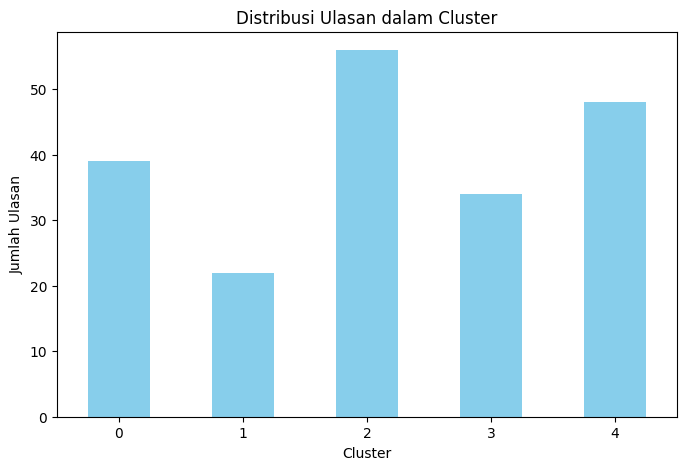

In [6]:
import matplotlib.pyplot as plt

# Membuat grafik distribusi cluster
plt.figure(figsize=(8, 5))
df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribusi Ulasan dalam Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.show()

In [3]:
# def recommend_by_cluster(title, df, n_recommendations=5):
#     # Mencari cluster dari ulasan yang diberikan
#     try:
#         cluster = df.loc[df['title'] == title, 'cluster'].values[0]
#     except IndexError:
#         return "Title tidak ditemukan dalam dataset."
    
#     # Mengambil ulasan dalam cluster yang sama
#     cluster_data = df[df['cluster'] == cluster]
    
#     # Jika cluster terlalu kecil
#     if len(cluster_data) < n_recommendations:
#         n_recommendations = len(cluster_data)
    
#     # Menampilkan ulasan lain dari cluster
#     recommendations = cluster_data.sample(n=n_recommendations)
#     return recommendations[['title', 'snippet', 'rating']]

# # Contoh rekomendasi
# title = "Seraphim"  # Judul ulasan
# recommendations = recommend_by_cluster(title, df)
# print(recommendations)

In [9]:
def recommend_by_snippet(snippet, df, n_recommendations=5):
    # Normalisasi casing dan hilangkan spasi ekstra pada snippet
    snippet = snippet.lower().strip()
    
    # Cari snippet yang paling mirip
    df['snippet_similarity'] = df['snippet'].apply(lambda x: text_similarity(snippet, x))
    
    # Urutkan berdasarkan kemiripan terbesar
    similar_snippets = df.sort_values(by='snippet_similarity', ascending=False)
    
    # Ambil rekomendasi dari cluster yang sama
    cluster = similar_snippets.iloc[0]['cluster']  # Ambil cluster dari snippet yang paling mirip
    cluster_data = df[df['cluster'] == cluster]
    
    # Jika cluster terlalu kecil
    if len(cluster_data) < n_recommendations:
        n_recommendations = len(cluster_data)
    
    # Tampilkan ulasan lain dari cluster yang sama
    recommendations = cluster_data.sample(n=n_recommendations)
    return recommendations[['title', 'snippet', 'rating']]

def text_similarity(snippet1, snippet2):
    # Menghitung kemiripan teks menggunakan cosine similarity atau metrik lain
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform([snippet1, snippet2])
    
    # Menghitung cosine similarity antara dua teks
    similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
    return similarity[0][0]

# Contoh pencarian berdasarkan snippet
snippet = "gensin"
recommendations = recommend_by_snippet(snippet, df)
print(recommendations)


           title                                            snippet  rating
17           Nex  ive played game years little release pretty fu...     5.0
73    Sonu Kadam  best action adventure game aver play smartphon...     5.0
14         Tim T  playing since sep game beautiful love differen...     3.0
111  LastFireFox  th anniversary weapon banner pitt along radian...     4.0
180  Albert Zhou  new rewards story quests long dialouge options...     2.0
